# Neural network on numpy
Study case: implementing a simple feedforward neural network on numpy, without using specialized libraries.

In [1]:
import numpy as np
from typing import List

In [2]:
class Layer:
    """
    Base class for neural network layer.
    All the layer types should inherit from it and implement two methods: forward and backward
    """
    def forward(self, x):
        pass

    def backward(self, dL_dz, learning_rate=0.):
        pass


class ReLU(Layer):
    """
    Rectified Linear Unit (ReLU) layer
    """
    def forward(self, x):
        """
        Forward pass - calculate the output of ReLU(x)
        
        x -- layer input of shape (N, in_dim), where N is batch size.
        """
        self._saved_input = x # we will need original input during backpropagation
        
        return x * (x > 0)


    def backward(self, dL_dz, learning_rate=0.):
        """
        Backpropagate through the layer.

        dL_dz -- gradient of the loss function calculated at previous backward step.
        learning_rate -- unused since ReLU doesn't have any parameters to train.
                         ReLU doesn't learn, it's an activation layer.
        
        Returns calculated derivative dL_dx.
        
        According to chain rule, dL_dx = dL_dz * dz_dx.
        For ReLU layer: dz_dx = 1 if x > 0
                        dz_dx = 0 if x < 0
                        dz_dx is non-differentiable at x = 0, but we'll arbitrarily chose it to be 0.
        """
        dz_dx = (self._saved_input > 0).astype(np.int32)
        
        return dz_dx * dL_dz

In [3]:
class FCLayer(Layer):
    """
    Fully connected (AKA dense) layer
    """
    def __init__(self, in_dim, out_dim):
        """
        in_dim, out_dim -- input and output layer dimensions
        """
        self.in_dim = in_dim
        self.out_dim = out_dim

        # Initialize weights matrix with random values sampled from standard normal distribution
        self.weights = np.random.default_rng().standard_normal(size=(in_dim, out_dim)) * 0.001
        # np.random.randn is commonly used to randomly initialize the weights, but, according to
        # documentation for more recent versions of numpy, it's a convenience function that
        # wraps `standard_normal` method of Generator object. 
        
        self.bias = np.zeros(self.out_dim)
        self._saved_input = None


    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Forward pass - calculate the layer output.

        x -- layer input with dimensions (N, in_dim), where N is batch size.

        Returns array of size (N, out_dim).
        """
        assert np.ndim(x) == 2
        assert x.shape[1] == self.in_dim
        
        self._saved_input = x
        
        return np.matmul(x, self.weights) + self.bias


    def backward(self, dL_dz, learning_rate=0.):
        """
        Backpropagate through the layer.
        
        dL_dz -- gradient of the loss function calculated at previous backward step.
                 Dimensions: (N, self.out_dim), where N is batch size.
        learning_rate -- if not equals 0, update weights and bias (do a gradient descent step)
        
        Returns calculated derivative dL_dx.
        """
        assert np.ndim(dL_dz) == 2
        assert dL_dz.shape[1] == self.out_dim
        
        # Backpropagation for a Linear Layer:
        # http://cs231n.stanford.edu/handouts/linear-backprop.pdf
        self.dL_dw = np.dot(self._saved_input.T, dL_dz)
        self.dL_dx = np.dot(dL_dz, self.weights.T)
        self.dL_db = dL_dz.sum(0) 
        
        assert self.dL_db.shape == self.bias.shape
        assert self.dL_dw.shape == self.weights.shape
        assert self.dL_dx.shape == self._saved_input.shape

        if learning_rate != 0:
            # Train layer: do a gradient descent step and update weights
            self.weights -= learning_rate * self.dL_dw
            self.bias -= learning_rate * self.dL_db
        
        return self.dL_dx

In [4]:
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

In [5]:
class Network:
    """
    A feedforward neural network implementation
    """
    def __init__(self, layers: List[Layer], loss_function: callable = None, loss_grad_function: callable = None):
        """
        Initializes neural network with given layers configuration.
        """
        self.layers = layers
        self.loss_function = loss_function
        self.loss_grad_function = loss_grad_function


    def forward(self, x: np.ndarray):
        """
        x -- input batch of size (N, input_layer_size)
        """
        output = x
        
        for layer in self.layers:
            output = layer.forward(output)
        
        return output


    def predict(self, x):
        """
        x -- input batch of size (N, input_layer_size)
        
        Returns vector of size (N) with predicted classes for each of the objects in input batch x.
        """
        logits = self.forward(x) # Get logits: do a full forward pass over the entire network.
        # Dimensions are (N, k) where k is the count of classes.
        
        classes = logits.argmax(axis=1)

        return classes
    
    
    def train_step(self, x, y, learning_rate):
        """
        x -- input batch of size (N, input_layer_size)
        y -- real classes (N,)
        """
        logits = self.forward(x)
        loss = self.loss_function(logits, y)
        loss_grad = self.loss_grad_function(logits, y)
        
        for layer in reversed(layers):
            loss_grad = layer.backward(loss_grad, learning_rate)

        return np.mean(loss)


    def fit(self, x_train, y_train, x_test, y_test, learning_rate, num_epochs, batch_size, show_progress=True):
        """
        Fitting cycle: iterate over minibatches, call train_step, store loss change and accuracy change log.
        """

        def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
            
            assert len(inputs) == len(targets)
            
            batches_range = range(0, len(inputs) - batchsize + 1, batchsize)
            
            if show_progress:
                batches_range = tqdm(batches_range)
            
            if shuffle:
                indices = np.random.permutation(len(inputs))
            
            for start_idx in batches_range:
                if shuffle:
                    batch_indexes = indices[start_idx:start_idx + batchsize]
                else:
                    batch_indexes = slice(start_idx, start_idx + batchsize)

                yield inputs[batch_indexes], targets[batch_indexes]
        
        
        train_log = []
        test_log = []
        loss_log = []

        for epoch in range(num_epochs):
            loss_iters = []
            for x_batch,y_batch in iterate_minibatches(x_train, y_train, batchsize=batch_size, shuffle=True):
                loss_iters.append(self.train_step(x_batch, y_batch, learning_rate=learning_rate))

            loss_log.append(np.mean(loss_iters)) # store mean loss at each iteration for visualisation
            train_accuracy = accuracy_score(y_train, self.predict(x_train))
            test_accuracy = accuracy_score(y_test, self.predict(x_test))
            train_log.append(train_accuracy)
            test_log.append(test_accuracy)

            if show_progress:
                clear_output()
                print("Epoch", epoch)
                print("Train accuracy:", train_log[-1])
                print("Test accuracy:", test_log[-1])
                plt.figure(figsize=(10, 5))
                ax1 = plt.subplot(1,2,1)    
                plt.plot(train_log,label='train accuracy')
                plt.plot(test_log,label='test accuracy')
                ax2 = plt.subplot(1,2,2)
                plt.plot(loss_log,label='loss')
                ax1.legend(loc='best')
                ax2.legend(loc='best')
                plt.grid()
                plt.tight_layout()
                plt.show()
        return

### Define a loss function

Categorical cross-entropy loss for object _**i**_ of class _**k**_ (https://gombru.github.io/2018/05/23/cross_entropy_loss/):

$$loss_i=-log(p_{i}^{k})$$
, where $p_{i}^{k}$ is predicted probability of object _**i**_ being of class _**k**_ (i.e. network's confidence in correct classification).

Such probability can be calculated by applying Softmax function to the neural network output (logits):

$$p_{i}^{k}=\frac{exp(logit_{i}^{k})}{\sum_{j=1}^{m}exp(logit_{i}^{j})}$$
, where $logit_{k}^{i}$ is non-activated network output for object _**i**_ of class _**k**_. Simplifying:

$$loss_i = -log(p_i^k) = -log(\frac{exp(logit_{i}^{k})}{\sum_{j=1}^{m}exp(logit_{i}^{j})}) = -logit_{i}^{k} + log(\sum_{j=0}^{m} exp(logit_{i}^{j}))$$

In [6]:
def multiclass_crossentropy_with_logits(logits, y_true):
    """
    logits -- network output without activation. Size: (N, k),
              where N -- objects count, k -- classes count.
    y_true -- true classes for N objects

    Returns vector with losses on each object.
    """

    logits_for_answers = logits[np.arange(len(logits)), y_true]
    
    cross_entropy = -logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return cross_entropy


def grad_multiclass_crossentropy_with_logits(logits, y_true):
    """
    Gradient of categorical cross-entropy loss function.
    
    logits -- network output without activation. Size: (N, k),
              where N -- objects count, k -- classes count.
    y_true -- true classes for N objects
    
    Returns matrix of derivatives.
    """
    
    true_indexes = np.zeros_like(logits)
    true_indexes[np.arange(len(logits)), y_true] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return softmax - true_indexes

That concludes implementation of all the classes needed for our network to work. Let's run some tests to check how different parts work, and in the end teach our network to classify handwritten numbers from MNIST dataset.

### Tests: general assertions

In [7]:
from matplotlib import pyplot as plt
from scipy.misc import derivative

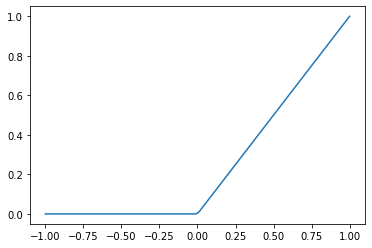

In [8]:
# Visualization of ReLU layer output
relu = ReLU()
plt.plot(np.linspace(-1, 1, 100), relu.forward(np.linspace(-1, 1, 100)))

Seems legit.

In [9]:
# Gradient calculation test
f = lambda x: ReLU().forward(x)

x = np.linspace(-1, 1, 10*32).reshape([10, 32])
l = ReLU()
l.forward(x)
grads = l.backward(np.ones([10, 32]))
numeric_grads = derivative(f, x, dx=1e-6)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
     "gradient returned by ReLU layer implementation doesn't match the numerically computed gradient"
print("Test passed")

Test passed


### Test classification on MNIST dataset

In [10]:
def show_mnist(images, labels, predicted_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {labels[i]}. Pred: {predicted_labels[i]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {labels[i]}")

(60000, 784) (10000, 784)


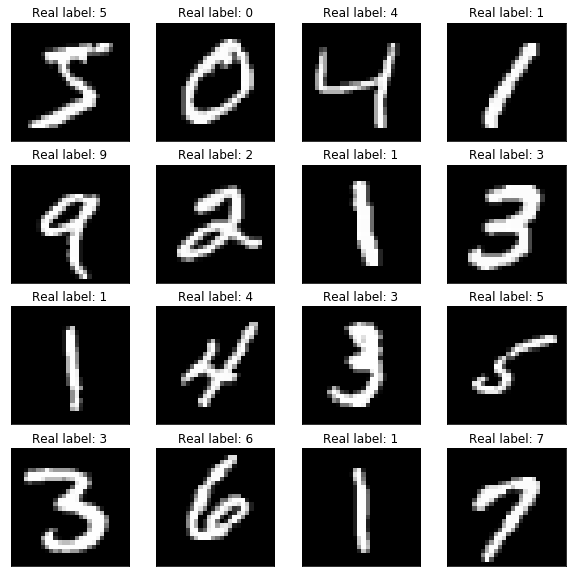

In [11]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

show_mnist(train_images, train_labels)

# преобразуем изображения к нужному виду
train_images = train_images.reshape(train_images.shape[0], -1).astype('float32') / 255.
test_images = test_images.reshape(test_images.shape[0], -1).astype('float32') / 255.
print(train_images.shape, test_images.shape)

Epoch 9
Train accuracy: 0.9924
Test accuracy: 0.9767


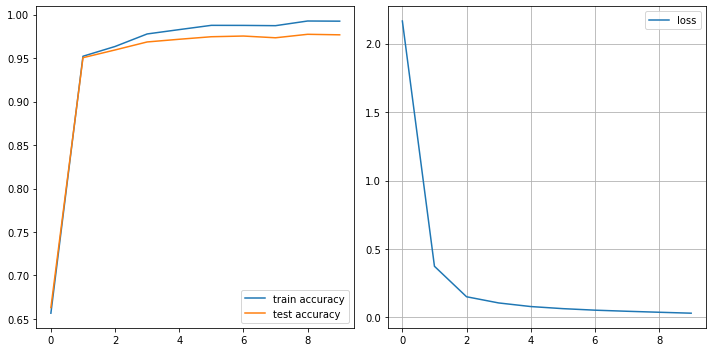

In [12]:
# Initialize layers: One hidden layer accepting 100 features and returning 200
#                    Output layer returning logits for 10 possible output classes
# ----------------------------------------------------------------------------------
# Let's build a simple network with one hidden layer.
# This will be enough to reach about 97% accuracy on MNIST dataset.
layers = []
layers.append(FCLayer(train_images.shape[1], 100)) # input layer
layers.append(ReLU()) # activation
layers.append(FCLayer(100, 200)) # hidden layer with 200 output features
layers.append(ReLU()) # activation
layers.append(FCLayer(200, 10)) # output layer; don't use activation since loss function expect logits, not probs.

net = Network(layers=layers, loss_function=multiclass_crossentropy_with_logits,
              loss_grad_function=grad_multiclass_crossentropy_with_logits)

net.fit(x_train=train_images, y_train=train_labels, 
        x_test=test_images, y_test=test_labels,
        batch_size=30, num_epochs=10, learning_rate=0.005)

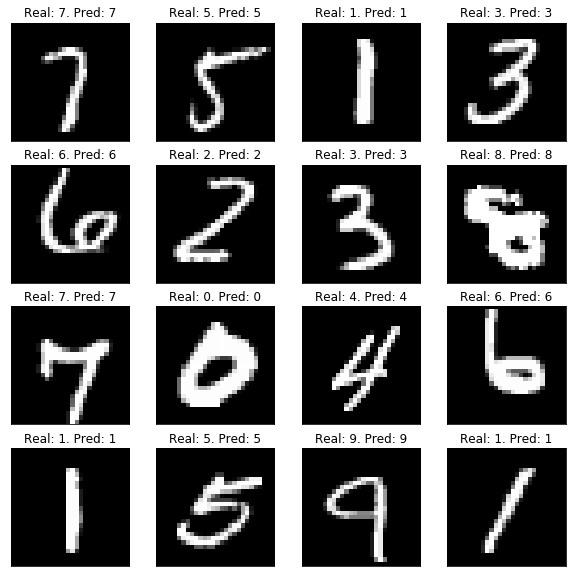

In [13]:
predicted_labels = net.predict(test_images)
idxs = np.random.choice(np.arange(len(test_images)), 16, replace=False)
show_mnist(test_images[idxs].reshape((-1, 28, 28)), test_labels[idxs], predicted_labels[idxs])